# 0.0 Introduction:

In this project I make an Exploratory Data Analysis on a dataset containing the record of the 50 bestselling books at Amazon in every year from 2009 to 2019 bestselling Amazon books in the range of years from 2009 to 2019. This dataset is publicly available at kaggle.

Besides it is also possible to implement a classification estimator to predict the genre of the books based in their titles. This classification will be shown below.

## 0.1 Import modules

In [1]:
#analysis

import numpy as np
import pandas as pd
import matplotlib as mat
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#prediction (classification)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import mean_squared_error, confusion_matrix

In [2]:
display('Numpy version: {}'.format(np.__version__))
display('Pandas version: {}'.format(pd.__version__))
display('Matplotlib version: {}'.format(mat.__version__))
display('Seaborn version: {}'.format(sns.__version__))

'Numpy version: 1.19.4'

'Pandas version: 1.2.0'

'Matplotlib version: 3.3.3'

'Seaborn version: 0.11.1'

## 0.2 Import data

In [3]:
best_sell = pd.read_csv('bestsellers_with_categories.csv')
best_sell.head()

Name  \
0                      10-Day Green Smoothie Cleanse   
1                                  11/22/63: A Novel   
2            12 Rules for Life: An Antidote to Chaos   
3                             1984 (Signet Classics)   
4  5,000 Awesome Facts (About Everything!) (Natio...   

                     Author  User Rating  Reviews  Price  Year        Genre  
0                  JJ Smith          4.7    17350      8  2016  Non Fiction  
1              Stephen King          4.6     2052     22  2011      Fiction  
2        Jordan B. Peterson          4.7    18979     15  2018  Non Fiction  
3             George Orwell          4.7    21424      6  2017      Fiction  
4  National Geographic Kids          4.8     7665     12  2019  Non Fiction

# 1.0 Data description

In [4]:
best_sell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         550 non-null    object 
 1   Author       550 non-null    object 
 2   User Rating  550 non-null    float64
 3   Reviews      550 non-null    int64  
 4   Price        550 non-null    int64  
 5   Year         550 non-null    int64  
 6   Genre        550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


The output above shows that there are no NA values.

I still much search for duplicates.

I will not change any data type.

Also, I will rename a column and the 'Non Fiction' Genre.

In [5]:
best_sell = best_sell.rename(columns={'User Rating':'User_Rating'})
best_sell = best_sell.replace({'Non Fiction':'Nonfiction'})

display(best_sell.columns)
display(best_sell.dtypes)

Index(['Name', 'Author', 'User_Rating', 'Reviews', 'Price', 'Year', 'Genre'], dtype='object')

Name            object
Author          object
User_Rating    float64
Reviews          int64
Price            int64
Year             int64
Genre           object
dtype: object

Check for duplicates:

In [6]:
best_sell.duplicated().sum()

0

Check if there are different versions of the names of the authors.

In [7]:
#list the authors using a Pandas series
auth_list = best_sell['Author']
auth_list

#split each entry
auth_split = auth_list.str.split()
auth_split

#create a dictionary, whose keys are the author surnames and the values are all names containing that surname:
from collections import defaultdict

lst_names = defaultdict(list)
for i in range(len(auth_split)):
    lst_names[auth_split[i][-1]].append(auth_split[i])

sorted(lst_names.items());

The result is a dictionary, as explained in the above cell. Since the authors are assembled by surname, it is easy to verify that there are names written in different ways. There are only two such cases, and these are unified in the cell below.

In [8]:
#'Daniel James Brown' is not 'Dan Brown'
#'George R.R. Martin' and 'George R. R. Martin' are the same
#'J.K. Rowling' and 'J. K. Rowling' are the same
best_sell2 = best_sell.replace({'J. K. Rowling':'J.K.Rowling', 'George R. R. Martin':'George R.R. Martin'})

## 1.1 Descriptive statistics of numerical data

In [9]:
num_data = best_sell.select_dtypes(include=['int64', 'float64']).drop(columns=['Year'])
num_data.describe().round(2)

User_Rating   Reviews   Price
count       550.00    550.00  550.00
mean          4.62  11953.28   13.10
std           0.23  11731.13   10.84
min           3.30     37.00    0.00
25%           4.50   4058.00    7.00
50%           4.70   8580.00   11.00
75%           4.80  17253.25   16.00
max           4.90  87841.00  105.00

The mean and median (50%) of the 'Price' attribute are much closer to min than to max. It is interesting to calculate kurtosis and skewness. Also, is the most expensive book an outlier?

In [10]:
price_skew = num_data['Price'].skew().round(3)
display('Skewness: {}'.format(price_skew))

price_kurt = num_data['Price'].kurt().round(3)
display('Kurtosis: {}'.format(price_kurt))

'Skewness: 3.685'

'Kurtosis: 22.434'

This data has positive skewness and high positive kurtosis. This value of kurtosis suggest the presence of outliers. This will be checked right away.

The kurtosis method of a Pandas series calculates the Fisher kurtosis, i.e., the kurtosis of a normal distribution, under this method, is zero.

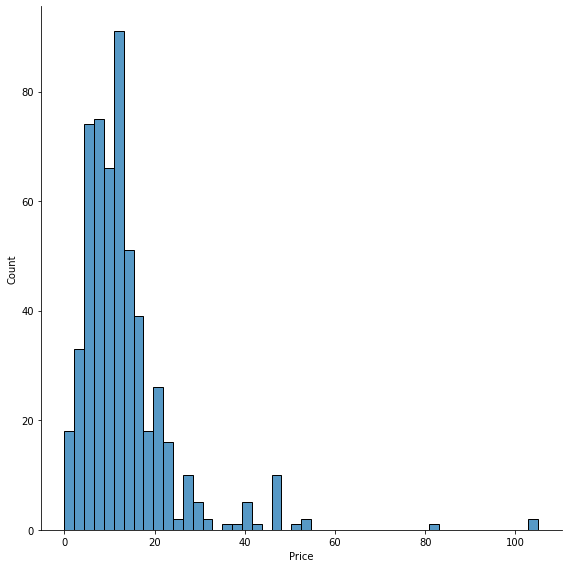

In [11]:
sns.displot(num_data['Price'], height=8);

There are two expensive books, one whose price is between \\$80 and \\$100, and another whose price is above \\$100. I'll exhibit them below. Also, I will exhibit the free books.

In [12]:
free = best_sell2.loc[best_sell2['Price'] == 0]
display(free)
expensive = best_sell2.loc[best_sell2['Price'] >= 80]
display(expensive)

Name  \
42          Cabin Fever (Diary of a Wimpy Kid, Book 6)   
71             Diary of a Wimpy Kid: Hard Luck, Book 8   
116                        Frozen (Little Golden Book)   
193                               JOURNEY TO THE ICE P   
219                                  Little Blue Truck   
358              The Constitution of the United States   
381                                        The Getaway   
461  The Short Second Life of Bree Tanner: An Eclip...   
505                              To Kill a Mockingbird   
506                              To Kill a Mockingbird   
507                              To Kill a Mockingbird   
508                              To Kill a Mockingbird   

                               Author  User_Rating  Reviews  Price  Year  \
42                        Jeff Kinney          4.8     4505      0  2011   
71                        Jeff Kinney          4.8     6812      0  2013   
116                         RH Disney          4.7     3642      0  2014   
193                         RH Disney          4.6      978      0  2014   
219                    Alice Schertle          4.9     1884      0  2014   
358  Delegates of the Constitutional
          4.8     2774      0  2016   
381                       Jeff Kinney          4.8     5836      0  2017   
461                   Stephenie Meyer          4.6     2122      0  2010   
505                        Harper Lee          4.8    26234      0  2013   
506                        Harper Lee          4.8    26234      0  2014   
507                        Harper Lee          4.8    26234      0  2015   
508                        Harper Lee          4.8    26234      0  2016   

          Genre  
42      Fiction  
71      Fiction  
116     Fiction  
193     Fiction  
219     Fiction  
358  Nonfiction  
381     Fiction  
461     Fiction  
505     Fiction  
506     Fiction  
507     Fiction  
508     Fiction

Name  \
69   Diagnostic and Statistical Manual of Mental Di...   
70   Diagnostic and Statistical Manual of Mental Di...   
473                       The Twilight Saga Collection   

                               Author  User_Rating  Reviews  Price  Year  \
69   American Psychiatric Association          4.5     6679    105  2013   
70   American Psychiatric Association          4.5     6679    105  2014   
473                   Stephenie Meyer          4.7     3801     82  2009   

          Genre  
69   Nonfiction  
70   Nonfiction  
473     Fiction

In [13]:
expensive['Name'].iloc[0]

'Diagnostic and Statistical Manual of Mental Disorders, 5th Edition: DSM-5'

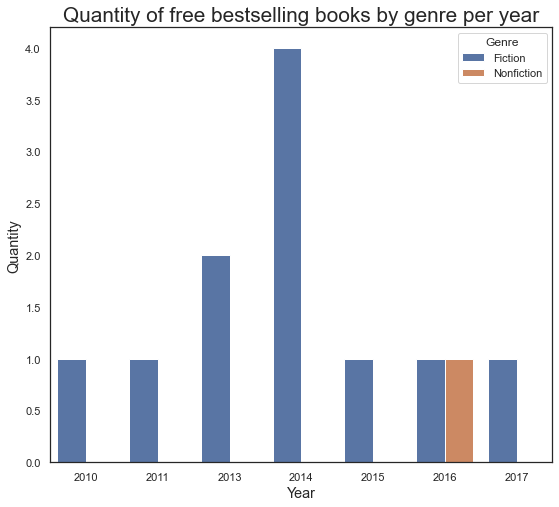

In [14]:
free_size = free.groupby(['Year', 'Genre']).size()
free_size.name="Size"
fr_size = pd.DataFrame(free_size).reset_index()

hst_mean = plt.figure(figsize=(9,8))

sns.set_theme(style="white")
sns.barplot(x=fr_size['Year'], y=fr_size['Size'], hue=fr_size['Genre']);
plt.xlabel('Year', size='large')
plt.ylabel('Quantity', size='large')
plt.title('Quantity of free bestselling books by genre per year', size='xx-large');

## 1.2 Description of bestselling books by author

In [15]:
author_count = best_sell2['Author'].value_counts()
author_count

Jeff Kinney                           12
Rick Riordan                          11
Suzanne Collins                       11
Gary Chapman                          11
American Psychological Association    10
                                      ..
Pete Souza                             1
M Prefontaine                          1
Larry Schweikart                       1
Steven D. Levitt                       1
Mark Owen                              1
Name: Author, Length: 247, dtype: int64

### 1.2.1 Jeff Kinney

In [16]:
j_Kinney = best_sell2.loc[best_sell2['Author'] == 'Jeff Kinney']
display(j_Kinney)
display(j_Kinney.drop('Year', axis=1).describe().round(2))

Name       Author  \
42          Cabin Fever (Diary of a Wimpy Kid, Book 6)  Jeff Kinney   
71             Diary of a Wimpy Kid: Hard Luck, Book 8  Jeff Kinney   
72       Diary of a Wimpy Kid: The Last Straw (Book 3)  Jeff Kinney   
73                 Diary of a Wimpy Kid: The Long Haul  Jeff Kinney   
80   Dog Days (Diary of a Wimpy Kid, Book 4) (Volum...  Jeff Kinney   
88              Double Down (Diary of a Wimpy Kid #11)  Jeff Kinney   
253              Old School (Diary of a Wimpy Kid #10)  Jeff Kinney   
381                                        The Getaway  Jeff Kinney   
435        The Meltdown (Diary of a Wimpy Kid Book 13)  Jeff Kinney   
468     The Third Wheel (Diary of a Wimpy Kid, Book 7)  Jeff Kinney   
474      The Ugly Truth (Diary of a Wimpy Kid, Book 5)  Jeff Kinney   
545       Wrecking Ball (Diary of a Wimpy Kid Book 14)  Jeff Kinney   

     User_Rating  Reviews  Price  Year    Genre  
42           4.8     4505      0  2011  Fiction  
71           4.8     6812      0  2013  Fiction  
72           4.8     3837     15  2009  Fiction  
73           4.8     6540     22  2014  Fiction  
80           4.8     3181     12  2009  Fiction  
88           4.8     5118     20  2016  Fiction  
253          4.8     6169      7  2015  Fiction  
381          4.8     5836      0  2017  Fiction  
435          4.8     5898      8  2018  Fiction  
468          4.7     6377      7  2012  Fiction  
474          4.8     3796     12  2010  Fiction  
545          4.9     9413      8  2019  Fiction

User_Rating  Reviews  Price
count        12.00    12.00  12.00
mean          4.80  5623.50   9.25
std           0.04  1694.98   7.36
min           4.70  3181.00   0.00
25%           4.80  4338.00   5.25
50%           4.80  5867.00   8.00
75%           4.80  6417.75  12.75
max           4.90  9413.00  22.00

### 1.2.2 Gary Chapman

In [17]:
g_Chapman = best_sell2.loc[best_sell2['Author'] == 'Gary Chapman']
display(g_Chapman)
display(g_Chapman.drop('Year', axis=1).describe().round(2))

Name        Author  \
320  The 5 Love Languages: The Secret to Love That ...  Gary Chapman   
321  The 5 Love Languages: The Secret to Love That ...  Gary Chapman   
322  The 5 Love Languages: The Secret to Love That ...  Gary Chapman   
323  The 5 Love Languages: The Secret to Love That ...  Gary Chapman   
324  The 5 Love Languages: The Secret to Love That ...  Gary Chapman   
325  The 5 Love Languages: The Secret to Love that ...  Gary Chapman   
326  The 5 Love Languages: The Secret to Love that ...  Gary Chapman   
327  The 5 Love Languages: The Secret to Love that ...  Gary Chapman   
328  The 5 Love Languages: The Secret to Love that ...  Gary Chapman   
329  The 5 Love Languages: The Secret to Love that ...  Gary Chapman   
374  The Five Love Languages: How to Express Heartf...  Gary Chapman   

     User_Rating  Reviews  Price  Year       Genre  
320          4.7     3477     28  2010  Nonfiction  
321          4.7     3477     28  2011  Nonfiction  
322          4.7     3477     28  2012  Nonfiction  
323          4.7     3477     28  2013  Nonfiction  
324          4.7     3477     28  2014  Nonfiction  
325          4.8    25554      8  2015  Nonfiction  
326          4.8    25554      8  2016  Nonfiction  
327          4.8    25554      8  2017  Nonfiction  
328          4.8    25554      8  2018  Nonfiction  
329          4.8    25554      8  2019  Nonfiction  
374          4.6      803      9  2009  Nonfiction

User_Rating   Reviews  Price
count        11.00     11.00  11.00
mean          4.74  13268.91  17.18
std           0.07  11787.38  10.36
min           4.60    803.00   8.00
25%           4.70   3477.00   8.00
50%           4.70   3477.00   9.00
75%           4.80  25554.00  28.00
max           4.80  25554.00  28.00

### 1.2.3 Rick Riordan

In [18]:
r_Riordan = best_sell2.loc[best_sell2['Author'] == 'Rick Riordan']
display(r_Riordan)
display(r_Riordan.drop('Year', axis=1).describe().round(2))

Name        Author  \
264  Percy Jackson and the Olympians Paperback Boxe...  Rick Riordan   
343   The Blood of Olympus (The Heroes of Olympus (5))  Rick Riordan   
406     The House of Hades (Heroes of Olympus, Book 4)  Rick Riordan   
418  The Last Olympian (Percy Jackson and the Olymp...  Rick Riordan   
419  The Last Olympian (Percy Jackson and the Olymp...  Rick Riordan   
428          The Lost Hero (Heroes of Olympus, Book 1)  Rick Riordan   
432     The Mark of Athena (Heroes of Olympus, Book 3)  Rick Riordan   
456      The Red Pyramid (The Kane Chronicles, Book 1)  Rick Riordan   
458  The Serpent's Shadow (The Kane Chronicles, Boo...  Rick Riordan   
463     The Son of Neptune (Heroes of Olympus, Book 2)  Rick Riordan   
469   The Throne of Fire (The Kane Chronicles, Book 2)  Rick Riordan   

     User_Rating  Reviews  Price  Year    Genre  
264          4.8      548      2  2010  Fiction  
343          4.8     6600     11  2014  Fiction  
406          4.8     6982     14  2013  Fiction  
418          4.8     4628      7  2009  Fiction  
419          4.8     4628      7  2010  Fiction  
428          4.8     4506     14  2010  Fiction  
432          4.8     6247     10  2012  Fiction  
456          4.6     2186     12  2010  Fiction  
458          4.8     2091     12  2012  Fiction  
463          4.8     4290     10  2011  Fiction  
469          4.7     1463     10  2011  Fiction

User_Rating  Reviews  Price
count        11.00    11.00  11.00
mean          4.77  4015.36   9.91
std           0.06  2170.60   3.51
min           4.60   548.00   2.00
25%           4.80  2138.50   8.50
50%           4.80  4506.00  10.00
75%           4.80  5437.50  12.00
max           4.80  6982.00  14.00

### 1.2.4 Suzanne Collins

In [19]:
s_Collins = best_sell2.loc[best_sell2['Author'] == 'Suzanne Collins']
display(s_Collins)
display(s_Collins.drop('Year', axis=1).describe().round(2))

Name           Author  User_Rating  \
46         Catching Fire (The Hunger Games)  Suzanne Collins          4.7   
47         Catching Fire (The Hunger Games)  Suzanne Collins          4.7   
48         Catching Fire (The Hunger Games)  Suzanne Collins          4.7   
236           Mockingjay (The Hunger Games)  Suzanne Collins          4.5   
237           Mockingjay (The Hunger Games)  Suzanne Collins          4.5   
238           Mockingjay (The Hunger Games)  Suzanne Collins          4.5   
407                        The Hunger Games  Suzanne Collins          4.7   
408               The Hunger Games (Book 1)  Suzanne Collins          4.7   
409               The Hunger Games (Book 1)  Suzanne Collins          4.7   
410  The Hunger Games Trilogy Boxed Set (1)  Suzanne Collins          4.8   
411  The Hunger Games Trilogy Boxed Set (1)  Suzanne Collins          4.8   

     Reviews  Price  Year    Genre  
46     22614     11  2010  Fiction  
47     22614     11  2011  Fiction  
48     22614     11  2012  Fiction  
236    26741      8  2010  Fiction  
237    26741      8  2011  Fiction  
238    26741      8  2012  Fiction  
407    32122     14  2010  Fiction  
408    32122      8  2011  Fiction  
409    32122      8  2012  Fiction  
410    16949     30  2011  Fiction  
411    16949     30  2012  Fiction

User_Rating   Reviews  Price
count        11.00     11.00  11.00
mean          4.66  25302.64  13.36
std           0.11   5540.49   8.45
min           4.50  16949.00   8.00
25%           4.60  22614.00   8.00
50%           4.70  26741.00  11.00
75%           4.70  29431.50  12.50
max           4.80  32122.00  30.00

### 1.2.5 American Psychological Association

In [20]:
amerPsyAssoc = best_sell2.loc[best_sell2['Author'] == 'American Psychological Association']
display(amerPsyAssoc)
display(amerPsyAssoc.drop('Year', axis=1).describe().round(2))

Name  \
271  Publication Manual of the American Psychologic...   
272  Publication Manual of the American Psychologic...   
273  Publication Manual of the American Psychologic...   
274  Publication Manual of the American Psychologic...   
275  Publication Manual of the American Psychologic...   
276  Publication Manual of the American Psychologic...   
277  Publication Manual of the American Psychologic...   
278  Publication Manual of the American Psychologic...   
279  Publication Manual of the American Psychologic...   
280  Publication Manual of the American Psychologic...   

                                 Author  User_Rating  Reviews  Price  Year  \
271  American Psychological Association          4.5     8580     46  2009   
272  American Psychological Association          4.5     8580     46  2010   
273  American Psychological Association          4.5     8580     46  2011   
274  American Psychological Association          4.5     8580     46  2012   
275  American Psychological Association          4.5     8580     46  2013   
276  American Psychological Association          4.5     8580     46  2014   
277  American Psychological Association          4.5     8580     46  2015   
278  American Psychological Association          4.5     8580     46  2016   
279  American Psychological Association          4.5     8580     46  2017   
280  American Psychological Association          4.5     8580     46  2018   

          Genre  
271  Nonfiction  
272  Nonfiction  
273  Nonfiction  
274  Nonfiction  
275  Nonfiction  
276  Nonfiction  
277  Nonfiction  
278  Nonfiction  
279  Nonfiction  
280  Nonfiction

User_Rating  Reviews  Price
count         10.0     10.0   10.0
mean           4.5   8580.0   46.0
std            0.0      0.0    0.0
min            4.5   8580.0   46.0
25%            4.5   8580.0   46.0
50%            4.5   8580.0   46.0
75%            4.5   8580.0   46.0
max            4.5   8580.0   46.0

### Remarks:
1. Jeff Kinney and Gary Chapman are the only authors which figure among the bestselling ones every year. The American Psychological Association did not figure among the bestselling ones only in 2019.
2. Suzanne Collins' books figured among the bestselling ones only from 2010 to 2012, but all of her books (and boxed sets of them) are present in all these years ("The Hunger Games" and "The Hunger Games (Book 1)" are the same).
3. Rick Riordan's books figured among the bestselling ones only from 2009 to 2014.
4. The book whose mean price is the highest is "Publication Manual of the American Psychological Association" (also the maximum price is the highest). It is possible that this is the most profitable book among the bestsellers, but it is not possible to check this hypothesis without the actual number of books sold.
5. There is no rating below 4.5.
6. There is a point requiring attention: the "Publication Manual of the American Psychological Association" received the same number of reviews every year, and the same average user rating.
7. The only woman among the 5 topseller authors is Suzanne Collins. This remark only considers the individual authors, because the "Publication Manual of the American Psychological Association" must have been written by men and women.

## 1.3 Description of bestselling books by genre

In [21]:
genre_size = best_sell2.groupby('Genre').size()
genre_size

Genre
Fiction       240
Nonfiction    310
dtype: int64

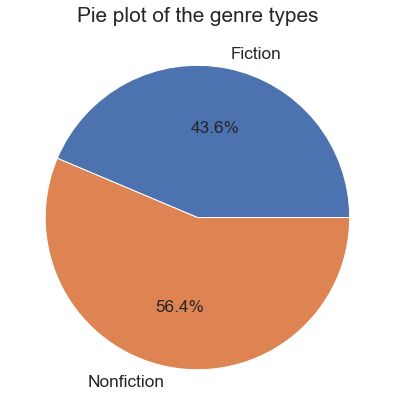

In [22]:
pie = plt.figure(figsize=(7,7))
labels = genre_size.index

plt.pie(x=genre_size, labels=labels, autopct='%.1f%%', textprops={'size':'x-large'});
plt.title('Pie plot of the genre types', size='xx-large');

Visualize the amount of bestselling books in each genre over the years

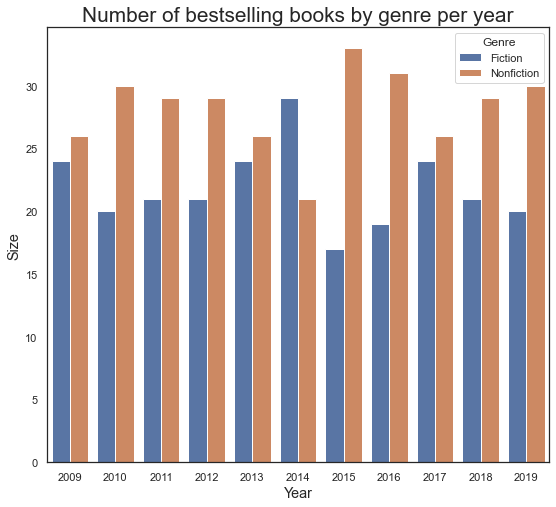

In [23]:
yr_genre = best_sell2[['Year', 'Genre']]

yr_genre_size = yr_genre.groupby(['Year', 'Genre']).size()
yr_genre_size.name="Size"
yr_size = pd.DataFrame(yr_genre_size).reset_index()
yr_size

hst = plt.figure(figsize=(9,8))

sns.set_theme(style="white")
sns.barplot(x=yr_size['Year'], y=yr_size['Size'], hue=yr_size['Genre']);
plt.xlabel('Year', size='large')
plt.ylabel('Size', size='large')
plt.title('Number of bestselling books by genre per year', size='xx-large');

Mean price of the bestselling books (by genre per year)

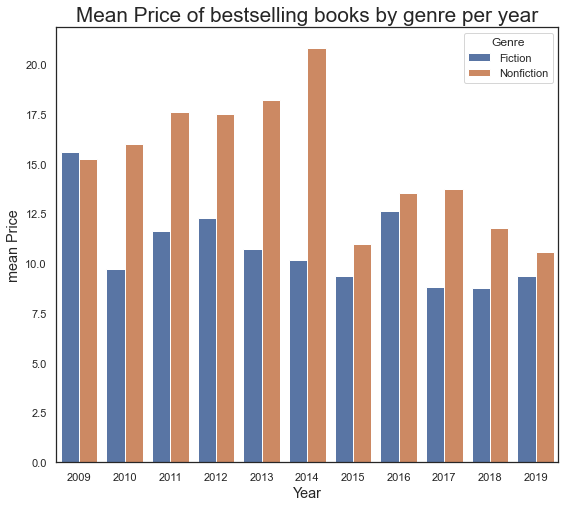

In [24]:
yr_gr_mean = best_sell2.groupby(['Year', 'Genre'])['Price'].mean().round(2)
yr_gr_mean.name='mean_Price'
yr_mean = pd.DataFrame(yr_gr_mean).reset_index()
yr_mean

hst_mean = plt.figure(figsize=(9,8))

sns.set_theme(style="white")
sns.barplot(x=yr_mean['Year'], y=yr_mean['mean_Price'], hue=yr_size['Genre']);
plt.xlabel('Year', size='large')
plt.ylabel('mean Price', size='large')
plt.title('Mean Price of bestselling books by genre per year', size='xx-large');

The high mean prices of Nonfiction books in the years 2013 and 2014 express the fact that the most expensive of all bestselling books were sold in these years and are Nonfiction books.

## 1.4 Description of author vs genre

In [25]:
auth_gnr = best_sell2[['Author', 'Genre']].sort_values(by=['Author'])
#create an array containing the authors who published fiction books
auth_fic = auth_gnr.loc[auth_gnr['Genre'] == 'Fiction']['Author'].to_numpy()
#create an array containing the authors who published nonfiction books
auth_nonfic = auth_gnr.loc[auth_gnr['Genre'] == 'Nonfiction']['Author'].to_numpy()

#function to verify if there is any author in both lists
def auth_in_both():
    
    counter = 0
    for a in auth_fic:
        if a in auth_nonfic:
            counter +=1
            print('The author {} published both Fiction and Nonfiction books.\n'.format(a))
    
    if counter == 0:
        print('No author published books of both genres.')
        

auth_in_both()

The author DK published both Fiction and Nonfiction books.

The author Scholastic published both Fiction and Nonfiction books.



What did these authors publish?

In [26]:
dk = best_sell2.loc[best_sell2['Author'] == 'DK']
schol = best_sell2.loc[best_sell2['Author'] == 'Scholastic']
display(dk)
display(schol)

Name Author  User_Rating  \
28                        Baby Touch and Feel: Animals     DK          4.6   
514  Ultimate Sticker Book: Frozen: More Than 60 Re...     DK          4.5   

     Reviews  Price  Year       Genre  
28      5360      5  2015  Nonfiction  
514     2586      5  2014     Fiction

Name      Author  \
158                         Harry Potter Coloring Book  Scholastic   
268  Pokémon Deluxe Essential Handbook: The Need-to...  Scholastic   

     User_Rating  Reviews  Price  Year       Genre  
158          4.7     3564      9  2015  Nonfiction  
268          4.7     3503      9  2016     Fiction

# 2.0 Classification

Now I will implement an estimator to classify the books into 'Fiction' and 'Nonfiction' based on their titles.

In [27]:
#target variable
y_s = best_sell2['Genre']
y = y_s.to_numpy()

#feature variable
X = best_sell2['Name'].to_numpy()

Before implementing the estimator, I must (Tfidf)Vectorize the data

In [28]:
tf = TfidfVectorizer()
X_vec = tf.fit_transform(X)
X_vec

<550x1169 sparse matrix of type '<class 'numpy.float64'>'
	with 3967 stored elements in Compressed Sparse Row format>

X_vec has 1169 features

## 2.1 Feature selection - dimensionality reduction

In order to find which among the more than 1100 features have a higher impact on the response variable, a Principal Component Analysis will be performed.

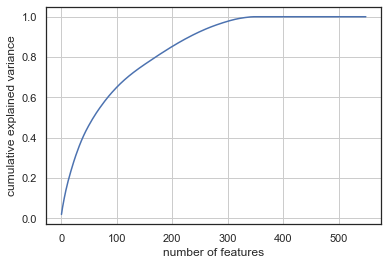

In [29]:
#must convert the sparse matrix into an array to pass it to the analyser:
X_arr = X_vec.toarray()
#instantiate analyser and run it
pca = PCA(svd_solver='randomized').fit(X_arr)
#plot
#fig = plt.figure()
#ax = fig.gca()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of features')
plt.ylabel('cumulative explained variance');

The above plot shows that almost 100% of the cumulative variance is explained by the first 350 principal components. Therefore the estimation will be made based on these features only.

In [30]:
pca = PCA(n_components=350, svd_solver='randomized')

X_pca = pca.fit_transform(X_arr)
X_pca.shape

(550, 350)

Before finishing this section, put target variable in the same "shape" of features variable.

## 2.2 Estimator - Random Forest Classifier

In [31]:
#Split the features and target variables into train and test. The splitting takes into account the
#different categories in the target variable. This stratification prevents a bias that would occur if
#most of the train set were taken from data within only one of the categories.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.8, random_state=42, stratify=y)

#Instantiate the classifier with 100 trees and specific random_state, for reproducibility
model = rf(n_estimators=100, random_state=50)

#fit, predict and print the score to have a preview of the results
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
scr = model.score(X_test, y_test)
print('Mean accuracy: {:.2%}'.format(scr))

#transform the target variables (test and predicted) into arrays to calculate the rmse
y_vec_test = tf.fit_transform(y_test).toarray()
y_vec_predict = tf.fit_transform(y_predict).toarray()
rms = mean_squared_error(y_vec_test, y_vec_predict, squared=False)
print('Root mean square error: {:.4f}'.format(rms))

Mean accuracy: 90.91%
Root mean square error: 0.3015


Repeat the train_test split, but using a StratifiedShuffleSplit to obtain different shufflings, all taking the classes into account. This must reduce possible biases due to an (in)convenient splitting. Also, choosing 5 foldings, this must give a convenient bias-variance tradeoff

In [32]:
#The sss cross-validator shuffles the samples before splitting them into train and test sets.
#The splitting takes into account the categories present in the target variable
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

'''
For every split (iteratively):
1. separate train and test sets;
2. fit and predict using the estimator 'model';
3. evaluate model score
4. evaluate rms - this step requires that the target be vectorized (again)
'''

for train_index, test_index in sss.split(X_pca,y):
    X_s_train, X_s_test, y_s_train, y_s_test = X_pca[train_index], X_pca[test_index], y[train_index], y[test_index]
    model.fit(X_s_train, y_s_train)
    y_s_predict = model.predict(X_s_test)
    scr_s = model.score(X_s_test, y_s_test)
    y_vec_s_test = tf.fit_transform(y_s_test).toarray()
    y_vec_s_predict = tf.fit_transform(y_s_predict).toarray()
    rms_s = mean_squared_error(y_vec_s_test, y_vec_s_predict, squared=False)
    print('Mean accuracy: {:.2%}; rms: {:.4f}'.format(scr_s,rms_s))

Mean accuracy: 90.91%; rms: 0.3015
Mean accuracy: 88.18%; rms: 0.3438
Mean accuracy: 88.18%; rms: 0.3438
Mean accuracy: 91.82%; rms: 0.2860
Mean accuracy: 95.45%; rms: 0.2132


The stratification maintained the accuracy at high levels. I'll repeat the estimation with a slightly larger test set

In [33]:
s_25 = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)


for train_index, test_index in s_25.split(X_pca,y):
    X_25_train, X_25_test, y_25_train, y_25_test = X_pca[train_index], X_pca[test_index], y[train_index], y[test_index]
    model.fit(X_25_train, y_25_train)
    y_25_predict = model.predict(X_25_test)
    scr_25 = model.score(X_25_test, y_25_test)
    y_vec_25_test = tf.fit_transform(y_25_test).toarray()
    y_vec_25_predict = tf.fit_transform(y_25_predict).toarray()
    rms_25 = mean_squared_error(y_vec_25_test, y_vec_25_predict, squared=False)
    print('Mean accuracy: {:.2%}; rms: {:.4f}'.format(scr_25,rms_25))

Mean accuracy: 90.58%; rms: 0.3069
Mean accuracy: 92.75%; rms: 0.2692
Mean accuracy: 90.58%; rms: 0.3069
Mean accuracy: 88.41%; rms: 0.3405
Mean accuracy: 89.86%; rms: 0.3185


There is no significant change in accuracy. The Random Forest Classifier provides a reliable API to predict the book genres based on their titles. The confusion matrix will be exhibited as a heat map to provide a visualization of the result.

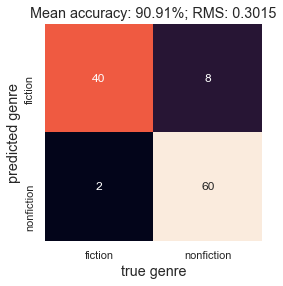

In [34]:
#get category names and save it as a variable to label the axes of the confusion matrix
y_temp = tf.fit_transform(y_train)
feat = tf.get_feature_names()

conf = confusion_matrix(y_test, y_predict)
#The matrix will be displayed as a heatmap
sns.heatmap(conf, square=True, annot=True, fmt='d', cbar=False, xticklabels=feat, yticklabels=feat)
plt.xlabel('true genre', size='large')
plt.ylabel('predicted genre', size='large')
plt.title('Mean accuracy: {:.2%}; RMS: {:.4f}'.format(scr,rms), size='large');

As the plot above shows, the book genres can be predicted from their titles with high accuracy. This result was not obvious from the beginning. Besides, the prediction was obtained using the Random Forest Classifier with only 100 trees. Let the number of trees be increased.

### 2.2.1 500 trees

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.8, random_state=42, stratify=y)

#Instantiate the classifier with 100 trees and specific random_state, for reproducibility
model_500 = rf(n_estimators=500, random_state=50)

#fit, predict and print the score to have a preview of the results
model_500.fit(X_train, y_train)
y_predict = model_500.predict(X_test)
scr = model_500.score(X_test, y_test)

#transform the target variables (test and predicted) into arrays to calculate the rmse
y_vec_test = tf.fit_transform(y_test).toarray()
y_vec_predict = tf.fit_transform(y_predict).toarray()
rms = mean_squared_error(y_vec_test, y_vec_predict, squared=False)
print('Mean accuracy: {:.2%}; RMS: {:.4f}'.format(scr,rms))

Mean accuracy: 90.91%; RMS: 0.3015


There is no significant change in the result. A mean accuracy of 90% with an rms of 0.3 is satisfactory for the present problem.

# 3.0 Conclusion

An Exploratory Data Analysis on a dataset containing the record of the 50 bestselling books at Amazon in every year from 2009 to 2019 was performed. It exhibited the presence of few books whose prices were high above average.

Besides, a classification estimator was implemented to predict the genres of the books based on their titles. The genres were predicted with 90% accuracy.

Common sense says that one must not judge a book by its cover. The programm above shows the extent to which such judgement can be made.